The first step in wrangling our EEG results is to import our datasets. They have been separated into 3 files, `run4.csv`, `run5.csv`, and `run4_5.txt`. The reason for this is that we wrote a `keylogger` (a program that captures the timing of keyboard inputs) that writes to one file, and we separated out the runs in the `OpenBCI` program. 

To import the raw EEG data, we will be using the `Pandas` Python module to read the raw CSV file into a `DataFrame`, which is an easily accessible large-scale format object for managing datasets. 

Once we have the DataFrames for the 2 selected runs, we need to combine them, so that we can access the entire dataset at once. `Pandas` will also help with this

In [311]:
import pandas as pd # Import Pandas to project
import numpy as np                                      
import matplotlib.pyplot as plt                         
import matplotlib.patches as patches
import seaborn as sns
import scipy.signal as signal 
from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [312]:
# Read run4.csv into Pandas DataFrame
run_3 = pd.read_csv(r'dataset/run3.csv')
run_4 = pd.read_csv(r'dataset/run4.csv')
run_5 = pd.read_csv(r'dataset/run5.csv')

eeg_data = pd.concat([run_4, run_5]).reset_index(drop=True)

eeg_data 

,Sample Index,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,Accel Channel 0,...,Other.3,Other.4,Other.5,Other.6,Analog Channel 0,Analog Channel 1,Analog Channel 2,Timestamp,Other.7,Timestamp (Formatted)
0,171.00000,6179.94442,2068.16221,-9348.55006,-324.45792,-591.33775,-1583.41993,-12547.66584,-13145.91028,0.05200,...,7.00000,208.00000,30.00000,208.00000,0.00000,0.00000,0.00000,1678313733.21671,0.00000,2023-03-08 14:15:33.216
1,172.00000,6184.52653,2071.13499,-9344.77262,-283.77775,-575.13274,-1581.56473,-12546.43649,-13146.46907,0.05200,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1678313733.21674,0.00000,2023-03-08 14:15:33.216
2,173.00000,6185.86763,2072.36434,-9343.85620,-361.22654,-581.57004,-1584.02343,-12544.93893,-13149.68773,0.05200,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1678313733.21675,0.00000,2023-03-08 14:15:33.216
3,174.00000,6186.67229,2071.64908,-9342.15746,-430.98634,-593.55057,-1585.36453,-12543.15079,-13155.65564,0.05200,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1678313733.21676,0.00000,2023-03-08 14:15:33.216
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.05200,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1678313733.29276,0.00000,2023-03-08 14:15:33.292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328820,184.00000,-1268.39444,-3476.34446,-9734.16236,-2671.12287,-4573.34573,-6089.30809,-13128.69944,-13841.11659,0.05800,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1678315269.78043,0.00000,2023-03-08 14:41:09.780
328821,185.00000,-1268.50620,-3475.18217,-9729.64731,-3879.41347,-4632.98018,-6111.30221,-13127.22422,-13850.01258,0.05800,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1678315269.78534,0.00000,2023-03-08 14:41:09.785
328822,186.00000,-1269.06499,-3474.95866,-9731.54720,-4805.75917,-4645.83244,-6106.02720,-13128.38651,-13845.02814,0.05800,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1678315269.78930,0.00000,2023-03-08 14:41:09.789
328823,187.00000,-1265.39931,-3476.85855,-9737.09044,-3011.27172,-4561.36519,-6075.49472,-13130.28641,-13830.83479,0.05800,...,8.00000,208.00000,30.00000,128.00000,0.00000,0.00000,0.00000,1678315269.79332,0.00000,2023-03-08 14:41:09.793


Now that the raw CSV files have been read into DataFrames, as can be seen above, there are many columns (or channels) of data, not all of which are necessary for our purposes, which are to read the raw EEG data. Given that, we can actually drop some of these columns, using the `df.drop()` function from Pandas. Doing this will increase the speed of our lookup algorithm in future cells. 

One problem this dataset has is that all of the column names were inputted to the CSV file with a space in the front, so we need to go and remove the space from each column name.

We only want the raw electrode data, and therefore only want the `EXG` channels, not the `accel` channels. Rather than manually input every channel to drop, we can instead filter the columns of the `DataFrame` by whether they include the `Accel, Other, Analog,` or `Formatted`, and then use that filtered `List` as the list of columns to drop!

In [313]:
eeg_cols_raw = eeg_data.columns # Read DataFrame columns into List

DISALLOWED_PHRASES = ['Accel', 'Other', 'Analog', 'Formatted', 'Sample'] # List of keywords not allowed in columns

eeg_cols_filtered = [] # Final Column list

for col in eeg_cols_raw: # For each column
    append = False
    for phrase in DISALLOWED_PHRASES: # For each phrase in the list
        if phrase in col: # If that phrase is in the column string
            append = True 
            break
    if append:
        eeg_cols_filtered.append(col)


eeg_data = eeg_data.drop(eeg_cols_filtered, axis=1) # Drop unnecessary columns

stripped_cols = []

for col in eeg_data.columns:
    stripped_cols.append(col.lstrip()) # Get rid of beginning space

eeg_data.columns = stripped_cols # Set columns

# eeg_data['Timestamp'] -= 28800

eeg_data

,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,Timestamp
0,6179.94442,2068.16221,-9348.55006,-324.45792,-591.33775,-1583.41993,-12547.66584,-13145.91028,1678313733.21671
1,6184.52653,2071.13499,-9344.77262,-283.77775,-575.13274,-1581.56473,-12546.43649,-13146.46907,1678313733.21674
2,6185.86763,2072.36434,-9343.85620,-361.22654,-581.57004,-1584.02343,-12544.93893,-13149.68773,1678313733.21675
3,6186.67229,2071.64908,-9342.15746,-430.98634,-593.55057,-1585.36453,-12543.15079,-13155.65564,1678313733.21676
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1678313733.29276
...,...,...,...,...,...,...,...,...,...
328820,-1268.39444,-3476.34446,-9734.16236,-2671.12287,-4573.34573,-6089.30809,-13128.69944,-13841.11659,1678315269.78043
328821,-1268.50620,-3475.18217,-9729.64731,-3879.41347,-4632.98018,-6111.30221,-13127.22422,-13850.01258,1678315269.78534
328822,-1269.06499,-3474.95866,-9731.54720,-4805.75917,-4645.83244,-6106.02720,-13128.38651,-13845.02814,1678315269.78930
328823,-1265.39931,-3476.85855,-9737.09044,-3011.27172,-4561.36519,-6075.49472,-13130.28641,-13830.83479,1678315269.79332


Now that we only have the required columns for analysis in our DataFrame, the next step is to add a `KeyPressed` column, whose entries will be the key the user was pressing at the time of the reading. 

A huge problem is that because our KeyLogger and OpenBCI run at different sampling rates, and they may not have been started at exactly the same time for each run, and differences in the computers, the timestamps may not exactly align between the KeyLogger output, and the EEG data. 

There is no perfect solution for this, but we feel that one that works well enough for our purposes is to get the keypress with the closest TimeStamp to our current sample. 

The first step to this is to read the KeyLogger result into two `Lists`, where the indeces match up exactly. The `timestamps` `List` will contain the `UNIX Timestamps` for each keypress converted into a DateTime object, and the `keys` `List` will contain the key pressed at that time. 

The reason we are using a `List` and not a `Dictionary` is that `Lists` are designed to be indexed and searched quickly, whereas `Dictionaries` often take much more time, and performing logical operations on them en-masse is very inefficient.

In [314]:
from datetime import datetime

timestamps = []
keys = []

with open(r'dataset/run4_5.txt') as key_file:
    for line in key_file:
        key = line.split(',')[0].replace("'", "")
        timestamp = float(line.split(',')[1].replace('\n', ''))

        timestamps.append(timestamp)
        keys.append(key)


obj = { 'Timestamp': timestamps, 'key': keys }

key_pressed = pd.DataFrame(data=obj)

key_pressed.sort_values('Timestamp')

key_pressed
print(key_pressed['key'].unique())


['f' 'w' '/' 'g' 'a' 'm' 'e' 'Key.tab' 'Key.space' 'c' 'Key.enter' 'd' 's'
 'u' 'r' 'Key.shift' 'A' 'W' 'S' 'D' 'Button.left' 'Button.right']


Now that we have the timestamps and keys imported and readable, we need to add the `KeyPressed` column, that contains the appropriate key.

In [315]:
def key_code(key):
    if (key == "w") | (key == "a") | ('key' == "s") | (key == "d") | (key == "W") | (key == "A") | ('key' == "S") | (key == "D"):
        return 1
    elif key == 'Button.left':
        return 2
    elif key == 'Button.right':
        return 3
    else:
        return 4
   
key_pressed['key'] = key_pressed['key'].apply(key_code)
to_drop = key_pressed.loc[key_pressed['key'] == 4]

key_pressed = key_pressed.drop(to_drop.index).reset_index(drop=True)
key_pressed.head()
print(key_pressed['key'].unique())

[1 2 3]


In [316]:
def get_closest_key_press(key, df_ts):
    '''
        Steps:
            - Find closest timestamp to curkey timestamp in eeg_data rows
            - Put key pressed as the current key in iteration in eeg_data
    '''
    result_index = eeg_data['Timestamp'].sub(df_ts).abs().idxmin()
    eeg_data['KeyPressed'][result_index] = key

def back_fill_empties(keyPressed):
    print(keyPressed)
    if keyPressed == 'None':
        return 'NO_KEY'
    return keyPressed

eeg_data['KeyPressed'] = None

key_pressed.apply(lambda x: get_closest_key_press(x['key'], x['Timestamp']), axis=1)

eeg_data['KeyPressed'] = eeg_data['KeyPressed'].fillna(value='NO_BUTTON')

#eeg_data.to_csv('eeg_val_to_key_press.csv')

In [317]:
eeg = eeg_data
print(eeg['KeyPressed'].unique())
eeg.head()

['NO_BUTTON' 1.0 2.0 3.0]


,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,Timestamp,KeyPressed
0,6179.94442,2068.16221,-9348.55006,-324.45792,-591.33775,-1583.41993,-12547.66584,-13145.91028,1678313733.21671,NO_BUTTON
1,6184.52653,2071.13499,-9344.77262,-283.77775,-575.13274,-1581.56473,-12546.43649,-13146.46907,1678313733.21674,NO_BUTTON
2,6185.86763,2072.36434,-9343.85620,-361.22654,-581.57004,-1584.02343,-12544.93893,-13149.68773,1678313733.21675,NO_BUTTON
3,6186.67229,2071.64908,-9342.15746,-430.98634,-593.55057,-1585.36453,-12543.15079,-13155.65564,1678313733.21676,NO_BUTTON
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1678313733.29276,NO_BUTTON


In [318]:
start_time_since_epoch = eeg['Timestamp'][0]
print(start_time_since_epoch)

def fix_time(time):
    return time - start_time_since_epoch
eeg['Timestamp'] = eeg['Timestamp'].apply(fix_time)

1678313733.216714


In [319]:
eeg.head()

,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,Timestamp,KeyPressed
0,6179.94442,2068.16221,-9348.55006,-324.45792,-591.33775,-1583.41993,-12547.66584,-13145.91028,0.00000,NO_BUTTON
1,6184.52653,2071.13499,-9344.77262,-283.77775,-575.13274,-1581.56473,-12546.43649,-13146.46907,0.00003,NO_BUTTON
2,6185.86763,2072.36434,-9343.85620,-361.22654,-581.57004,-1584.02343,-12544.93893,-13149.68773,0.00003,NO_BUTTON
3,6186.67229,2071.64908,-9342.15746,-430.98634,-593.55057,-1585.36453,-12543.15079,-13155.65564,0.00004,NO_BUTTON
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.07605,NO_BUTTON


Resampling for constant frequency

In [320]:
import mne
data_path = r'eeg_val_to_key_press.csv'

# Load the CSV data into a NumPy array
data = pd.DataFrame(eeg['Timestamp'], columns = ['Timestamp'])
data[eeg.columns[:8]] = eeg[eeg.columns[:8]]
data=np.array(data)

# Define the time values for each sample
time_values = eeg['Timestamp']

# Calculate the average time between samples
avg_delta_t = np.mean(np.diff(time_values))

# Create a MNE-Python Info object to store information about the data
n_channels = 8  # Set the number of EEG channels
ch_names = ['Fp1', 'T3', 'C3', 'C4', 'T4', 'Fz', 'Cz', 'Pz']  # Set the channel names
ch_types = ['eeg'] * n_channels  # Set the channel types to 'eeg' for all channels
info = mne.create_info(ch_names=ch_names, sfreq=1/avg_delta_t, ch_types=ch_types)

# Create a MNE-Python RawArray object to store the EEG data
data_values = data[:, 1:]
raw = mne.io.RawArray(data_values.T, info)

# Resample the data to a new sampling rate (in Hz)
new_fs = 250
raw_resampled = raw.resample(new_fs)

# Print some basic information about the EEG data
print(raw_resampled.info)

Creating RawArray with float64 data, n_channels=8, n_times=328825
    Range : 0 ... 328824 =      0.000 ...  1536.580 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, T3, C3, C4, T4, Fz, Cz, Pz
 chs: 8 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 107.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>


In [321]:
events = pd.DataFrame(list(eeg['Timestamp'].loc[eeg['KeyPressed'] != 'NO_BUTTON']), columns = ['Timestamp'])

events['duration'] = 0

events['key'] = list(eeg['KeyPressed'].loc[eeg['KeyPressed'] != 'NO_BUTTON'])
events['Timestamp'] = events['Timestamp'].astype(int)
events['key'] = events['key'].astype(int)
#events_array = np.rec.fromrecords(events[['time', 'duration', 'key']].values.tolist(),
 #                                  names='onset,duration,event_id')

# read events with MNE function
#events = mne.read_events(events_array)
#events = mne.read_events(events_array)
#events = np.array(events)
#new_events = []
#for event in events:
 #   temp = []
 #   for e in event:
 #      temp.append(int(e))
 #   new_events.append(temp)
print(events)  
#events.shape

      Timestamp  duration  key
0            12         0    1
1            12         0    1
2            15         0    1
3            20         0    1
4            20         0    1
...         ...       ...  ...
1362       1528         0    3
1363       1529         0    3
1364       1530         0    3
1365       1535         0    2
1366       1536         0    2

[1367 rows x 3 columns]


In [322]:
raw_resampled.times
sdt = raw_resampled.times[1] - raw_resampled.times[0]
sdt

0.004

In [323]:
mne.write_events('events.fif', events, overwrite=True)

Overwriting existing file.


C:\Users\Carly Freedman\AppData\Local\Temp\ipykernel_30684\3511839828.py:1: RuntimeWarning: This filename (c:\Users\Carly Freedman\Documents\GitHub\Winter 23\COGS 189\Final-Project-Cogs-189\events.fif) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst or _eve.txt
  mne.write_events('events.fif', events, overwrite=True)


In [324]:
freq_low = 1 # lower frequency bound in Hz
freq_high = 30  # higher frequency bound in Hz
filter_order = 4  # filter order (4 is commonly used)

# apply bandpass filter to EEG data
raw_filtered = raw_resampled.filter(l_freq=freq_low, h_freq=freq_high, 
                          filter_length='auto', phase='zero',
                          fir_design='firwin', n_jobs=-1, 
                          l_trans_bandwidth='auto', 
                          h_trans_bandwidth='auto',
                          verbose=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    4.6s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    4.6s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    4.6s finished


In [355]:
events = np.array(events)

data=raw_resampled.get_data()
# specify epoch duration and overlap
epoch_duration = 12.0  # in seconds
overlap = 1  # as a fraction of epoch_duration

# calculate the number of samples in an epoch
sfreq = raw_resampled.info['sfreq']
epoch_samples = int(epoch_duration * sfreq)

# calculate the number of overlapping samples
overlap_samples = int(overlap * epoch_samples)

# create an empty array to store the epochs
epochs_data = np.empty((8, len(events), epoch_samples))

# loop through each event and extract the epoch
for j in range(8):
    for i, event in enumerate(events):
        start_sample = event[0] * sfreq
        end_sample = start_sample + epoch_samples
        
        # check if the epoch goes beyond the end of the data
        if end_sample >= len(data[j]):
            print(sfreq)
            print(start_sample)
            print(epoch_samples)
            print(len(data))
            break
        
        # extract the epoch and store it in the array
        epochs_data[j][i] = data[j][int(start_sample):int(end_sample)]
       
    
print(epochs_data)

250.0
381250.0
3000
8
250.0
381250.0
3000
8
250.0
381250.0
3000
8
250.0
381250.0
3000
8
250.0
381250.0
3000
8
250.0
381250.0
3000
8
250.0
381250.0
3000
8
250.0
381250.0
3000
8
[[[ 26.22583817  23.76376878  21.87100632 ... -21.481642   -25.94003057
   -27.71640674]
  [ 26.22583817  23.76376878  21.87100632 ... -21.481642   -25.94003057
   -27.71640674]
  [ -3.83634455  -0.91480434  -0.63075888 ...  35.28184605  34.35327107
    34.11784536]
  ...
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]]

 [[ -4.62146872  -9.86651214 -12.99268078 ... -19.19525584 -26.7395333
   -34.05618538]
  [ -4.62146872  -9.86651214 -12.99268078 ... -19.19525584 -26.7395333
   -34.05618538]
  [  6.45625761   3.76586479   1.31313073 ...  10.89916061   5.43841011
     0.25210446]
  ...
  [  0.           0.           0.  

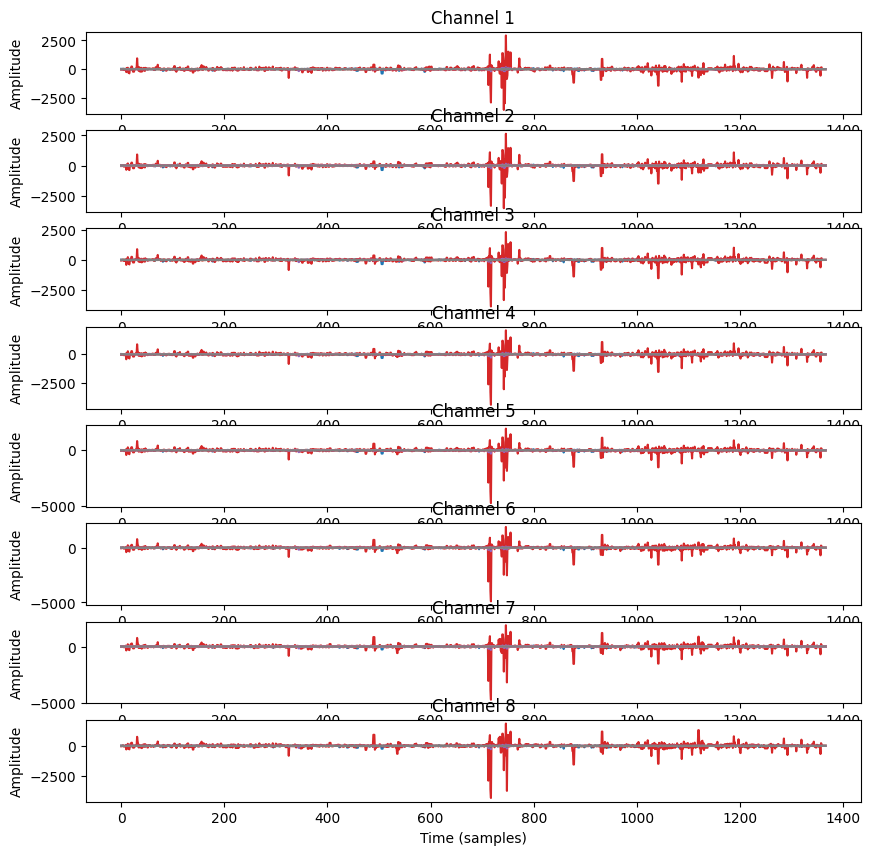

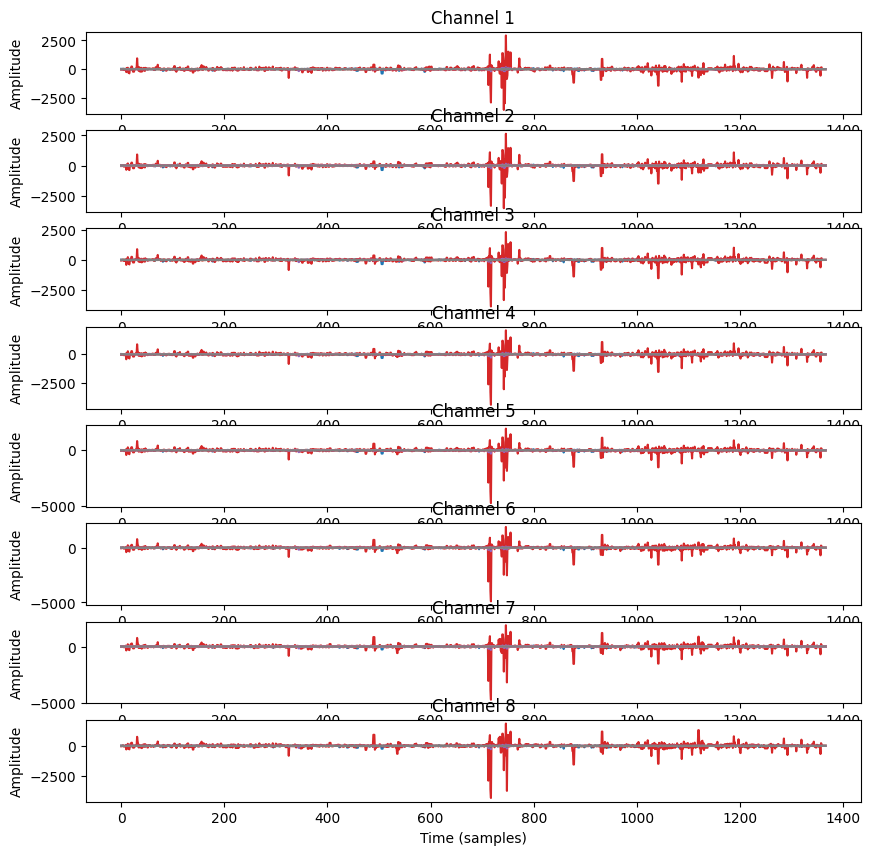

In [358]:
n_channels = 8
fig, axes = plt.subplots(nrows=n_channels, ncols=1, figsize=(10, 10))

# Plot each channel's data in a subplot
for i in range(n_channels):
    axes[i].plot(epochs_data[:, :, i].T)
    axes[i].set_xlabel('Time (samples)')
    axes[i].set_ylabel('Amplitude')
    axes[i].set_title('Channel {}'.format(i+1))
plt.show()

Using data from preloaded Raw for 648 events and 131251 original time points ...
648 bad epochs dropped


C:\Users\Carly Freedman\AppData\Local\Temp\ipykernel_30684\3423980154.py:11: RuntimeWarning: Mean of empty slice.
  average_data = channel_data.mean(axis=0)
c:\Users\Carly Freedman\Documents\GitHub\Winter 23\env\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


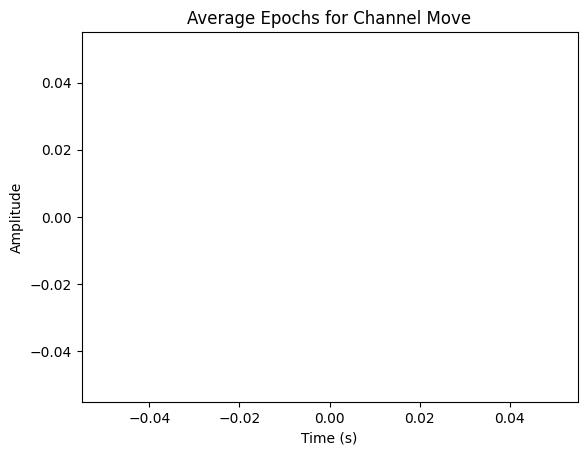